# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

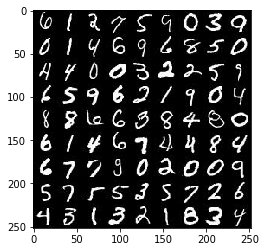

In [2]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

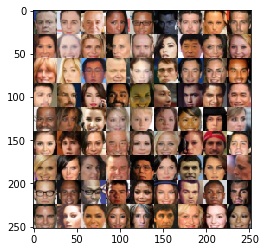

In [3]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h1 = tf.layers.dropout(inputs=h1, rate=dropout, training=False)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h2 = tf.layers.dropout(inputs=h2, rate=dropout, training=False)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h3 = tf.layers.dropout(inputs=h3, rate=dropout, training=False)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        h4 = tf.layers.conv2d(h3, 512, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h4 = tf.layers.dropout(inputs=h4, rate=dropout, training=False)
        h4 = tf.layers.batch_normalization(h4, training=True)
        h4 = tf.maximum(alpha * h4, h4)
        
        flat = tf.reshape(h4, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512,kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        # 28x28x5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=leaky_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting the training")    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    
    print("Finished the training")                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting the training
Step: 10: Epoch 1/2... Discriminator Loss: 7.6034... Generator Loss: 0.0027
Step: 20: Epoch 1/2... Discriminator Loss: 3.4551... Generator Loss: 15.2593
Step: 30: Epoch 1/2... Discriminator Loss: 2.1219... Generator Loss: 0.5494
Step: 40: Epoch 1/2... Discriminator Loss: 2.7178... Generator Loss: 0.1529
Step: 50: Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.6880
Step: 60: Epoch 1/2... Discriminator Loss: 1.5354... Generator Loss: 7.0049
Step: 70: Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.6434
Step: 80: Epoch 1/2... Discriminator Loss: 4.2116... Generator Loss: 0.0417
Step: 90: Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 6.2000
Step: 100: Epoch 1/2... Discriminator Loss: 0.6770... Generator Loss: 2.7902


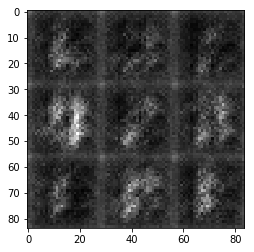

Step: 110: Epoch 1/2... Discriminator Loss: 0.7266... Generator Loss: 2.2241
Step: 120: Epoch 1/2... Discriminator Loss: 2.8085... Generator Loss: 0.1635
Step: 130: Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.4055
Step: 140: Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.7147
Step: 150: Epoch 1/2... Discriminator Loss: 2.0303... Generator Loss: 0.3266
Step: 160: Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.9820
Step: 170: Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 5.1014
Step: 180: Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.9122
Step: 190: Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 0.5437
Step: 200: Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 3.7041


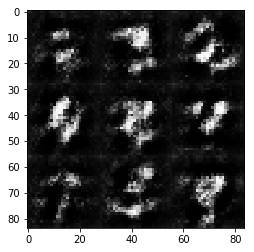

Step: 210: Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.3022
Step: 220: Epoch 1/2... Discriminator Loss: 0.4832... Generator Loss: 2.2326
Step: 230: Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.4830
Step: 240: Epoch 1/2... Discriminator Loss: 2.2836... Generator Loss: 0.2219
Step: 250: Epoch 1/2... Discriminator Loss: 3.0234... Generator Loss: 0.1113
Step: 260: Epoch 1/2... Discriminator Loss: 2.1904... Generator Loss: 0.3407
Step: 270: Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.4992
Step: 280: Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 0.9370
Step: 290: Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 2.4327
Step: 300: Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 1.9754


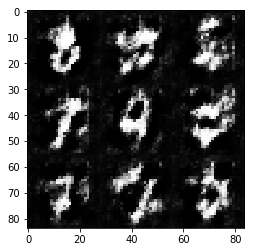

Step: 310: Epoch 1/2... Discriminator Loss: 0.4995... Generator Loss: 2.2783
Step: 320: Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.0867
Step: 330: Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.8057
Step: 340: Epoch 1/2... Discriminator Loss: 0.5233... Generator Loss: 2.8257
Step: 350: Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.6934
Step: 360: Epoch 1/2... Discriminator Loss: 0.7064... Generator Loss: 1.3535
Step: 370: Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.5628
Step: 380: Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 5.0100
Step: 390: Epoch 1/2... Discriminator Loss: 1.0079... Generator Loss: 0.9551
Step: 400: Epoch 1/2... Discriminator Loss: 0.5737... Generator Loss: 1.7584


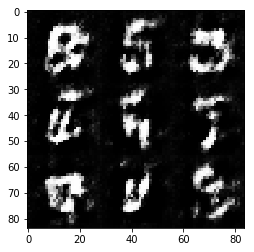

Step: 410: Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.9032
Step: 420: Epoch 1/2... Discriminator Loss: 0.4743... Generator Loss: 3.2016
Step: 430: Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.4669
Step: 440: Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.5817
Step: 450: Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 5.4653
Step: 460: Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.8523
Step: 470: Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 1.9408
Step: 480: Epoch 1/2... Discriminator Loss: 1.8319... Generator Loss: 6.6315
Step: 490: Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.1180
Step: 500: Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.0270


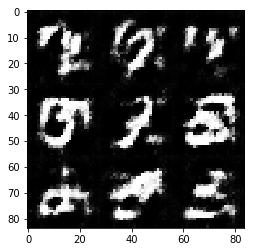

Step: 510: Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.5227
Step: 520: Epoch 1/2... Discriminator Loss: 2.5749... Generator Loss: 0.1486
Step: 530: Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.6468
Step: 540: Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 1.1509
Step: 550: Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.2109
Step: 560: Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 2.2066
Step: 570: Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.7058
Step: 580: Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 3.9149
Step: 590: Epoch 1/2... Discriminator Loss: 0.6051... Generator Loss: 5.9856
Step: 600: Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.8078


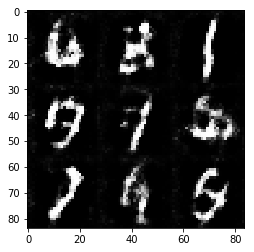

Step: 610: Epoch 1/2... Discriminator Loss: 3.1690... Generator Loss: 0.1552
Step: 620: Epoch 1/2... Discriminator Loss: 2.0052... Generator Loss: 0.4529
Step: 630: Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 2.3072
Step: 640: Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 0.8628
Step: 650: Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.6976
Step: 660: Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 1.1670
Step: 670: Epoch 1/2... Discriminator Loss: 0.4923... Generator Loss: 4.5706
Step: 680: Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.0211
Step: 690: Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.1717
Step: 700: Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.2336


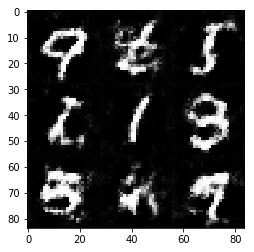

Step: 710: Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 0.7583
Step: 720: Epoch 1/2... Discriminator Loss: 2.5545... Generator Loss: 0.2693
Step: 730: Epoch 1/2... Discriminator Loss: 0.4401... Generator Loss: 2.8230
Step: 740: Epoch 1/2... Discriminator Loss: 2.4691... Generator Loss: 0.2303
Step: 750: Epoch 1/2... Discriminator Loss: 3.5206... Generator Loss: 0.0882
Step: 760: Epoch 1/2... Discriminator Loss: 3.1586... Generator Loss: 0.1142
Step: 770: Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8988
Step: 780: Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 1.9948
Step: 790: Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 1.9855
Step: 800: Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.1588


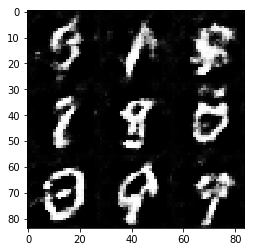

Step: 810: Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.1664
Step: 820: Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 1.2404
Step: 830: Epoch 1/2... Discriminator Loss: 1.9854... Generator Loss: 0.3059
Step: 840: Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.4970
Step: 850: Epoch 1/2... Discriminator Loss: 0.8950... Generator Loss: 1.0956
Step: 860: Epoch 1/2... Discriminator Loss: 0.4661... Generator Loss: 5.2207
Step: 870: Epoch 1/2... Discriminator Loss: 0.7453... Generator Loss: 1.3791
Step: 880: Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 3.2991
Step: 890: Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.0272
Step: 900: Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 1.3914


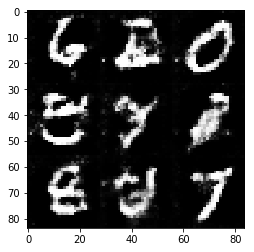

Step: 910: Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.4930
Step: 920: Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 2.0998
Step: 930: Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 1.1857
Step: 940: Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.5705
Step: 950: Epoch 1/2... Discriminator Loss: 0.5233... Generator Loss: 2.0151
Step: 960: Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.8524
Step: 970: Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 2.0826
Step: 980: Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 1.0052
Step: 990: Epoch 1/2... Discriminator Loss: 2.6462... Generator Loss: 0.1784
Step: 1000: Epoch 1/2... Discriminator Loss: 2.3121... Generator Loss: 0.2390


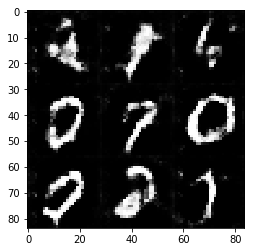

Step: 1010: Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.9081
Step: 1020: Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.9544
Step: 1030: Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 3.1750
Step: 1040: Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0758
Step: 1050: Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 2.9627
Step: 1060: Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.7950
Step: 1070: Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 8.0843
Step: 1080: Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 1.7098
Step: 1090: Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.6077
Step: 1100: Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 1.9068


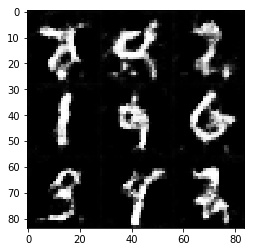

Step: 1110: Epoch 1/2... Discriminator Loss: 1.8368... Generator Loss: 0.4052
Step: 1120: Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 1.6235
Step: 1130: Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 2.5200
Step: 1140: Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.7648
Step: 1150: Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 7.4045
Step: 1160: Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.6387
Step: 1170: Epoch 1/2... Discriminator Loss: 0.4671... Generator Loss: 2.8091
Step: 1180: Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 1.2404
Step: 1190: Epoch 1/2... Discriminator Loss: 0.8026... Generator Loss: 1.0791
Step: 1200: Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 3.2957


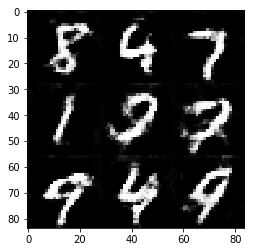

Step: 1210: Epoch 1/2... Discriminator Loss: 2.7485... Generator Loss: 0.1865
Step: 1220: Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.6366
Step: 1230: Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 4.0604
Step: 1240: Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.7074
Step: 1250: Epoch 1/2... Discriminator Loss: 3.1956... Generator Loss: 0.1044
Step: 1260: Epoch 1/2... Discriminator Loss: 2.3468... Generator Loss: 0.2602
Step: 1270: Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.9824
Step: 1280: Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.7477
Step: 1290: Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 1.7228
Step: 1300: Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 1.0774


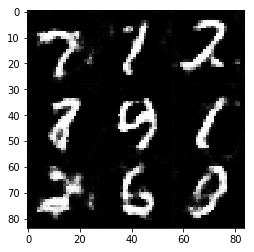

Step: 1310: Epoch 1/2... Discriminator Loss: 2.8396... Generator Loss: 0.1242
Step: 1320: Epoch 1/2... Discriminator Loss: 2.1411... Generator Loss: 0.2802
Step: 1330: Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 1.4232
Step: 1340: Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 1.5256
Step: 1350: Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.5624
Step: 1360: Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.6339
Step: 1370: Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.5011
Step: 1380: Epoch 1/2... Discriminator Loss: 2.3974... Generator Loss: 0.2271
Step: 1390: Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.6782
Step: 1400: Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 3.3334


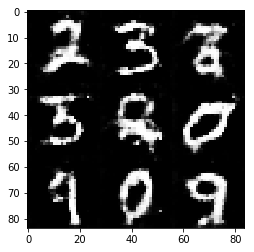

Step: 1410: Epoch 1/2... Discriminator Loss: 1.8575... Generator Loss: 0.3614
Step: 1420: Epoch 1/2... Discriminator Loss: 0.5596... Generator Loss: 1.9080
Step: 1430: Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 0.8013
Step: 1440: Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 0.8909
Step: 1450: Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 1.5981
Step: 1460: Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.6124
Step: 1470: Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 1.3512
Step: 1480: Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.2776
Step: 1490: Epoch 1/2... Discriminator Loss: 0.9830... Generator Loss: 0.8388
Step: 1500: Epoch 1/2... Discriminator Loss: 0.4267... Generator Loss: 3.0797


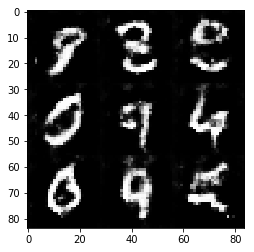

Step: 1510: Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.1613
Step: 1520: Epoch 1/2... Discriminator Loss: 0.6764... Generator Loss: 1.5332
Step: 1530: Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 0.9769
Step: 1540: Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.4592
Step: 1550: Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.7896
Step: 1560: Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 2.4242
Step: 1570: Epoch 1/2... Discriminator Loss: 0.4997... Generator Loss: 2.3056
Step: 1580: Epoch 1/2... Discriminator Loss: 0.8664... Generator Loss: 1.0506
Step: 1590: Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 1.6729
Step: 1600: Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.0230


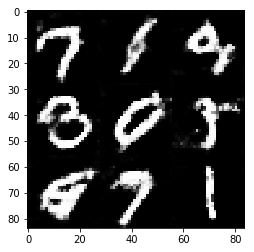

Step: 1610: Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.5161
Step: 1620: Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 1.8139
Step: 1630: Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.9782
Step: 1640: Epoch 1/2... Discriminator Loss: 0.4256... Generator Loss: 2.6284
Step: 1650: Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.0213
Step: 1660: Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 4.8040
Step: 1670: Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 1.6294
Step: 1680: Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.2157
Step: 1690: Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 3.6531
Step: 1700: Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 1.9413


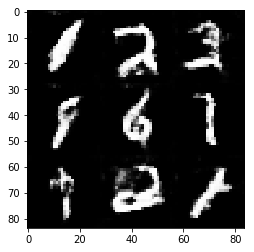

Step: 1710: Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.0245
Step: 1720: Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.3442
Step: 1730: Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.1670
Step: 1740: Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 0.9939
Step: 1750: Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 0.9583
Step: 1760: Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 1.2706
Step: 1770: Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.8551
Step: 1780: Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.7202
Step: 1790: Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.6017
Step: 1800: Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 1.4969


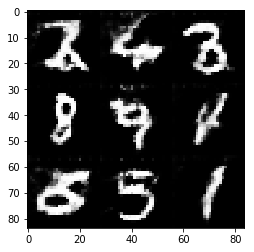

Step: 1810: Epoch 1/2... Discriminator Loss: 0.8544... Generator Loss: 1.1058
Step: 1820: Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 8.8126
Step: 1830: Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 3.5977
Step: 1840: Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.4978
Step: 1850: Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.7819
Step: 1860: Epoch 1/2... Discriminator Loss: 1.7648... Generator Loss: 0.3898
Step: 1870: Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 0.8012
Step: 1880: Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.3182
Step: 1890: Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.1361
Step: 1900: Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.1149


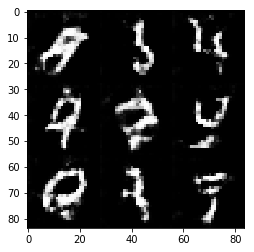

Step: 1910: Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 2.5748
Step: 1920: Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.5465
Step: 1930: Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.5839
Step: 1940: Epoch 2/2... Discriminator Loss: 2.4400... Generator Loss: 0.2057
Step: 1950: Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.3335
Step: 1960: Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.1815
Step: 1970: Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.7770
Step: 1980: Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.8664
Step: 1990: Epoch 2/2... Discriminator Loss: 2.0715... Generator Loss: 0.2562
Step: 2000: Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 1.0501


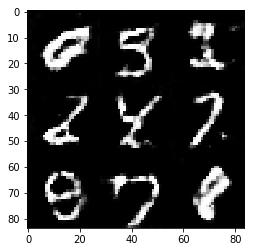

Step: 2010: Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.6603
Step: 2020: Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.6559
Step: 2030: Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 2.2541
Step: 2040: Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.5823
Step: 2050: Epoch 2/2... Discriminator Loss: 1.7970... Generator Loss: 0.3874
Step: 2060: Epoch 2/2... Discriminator Loss: 1.7315... Generator Loss: 0.4521
Step: 2070: Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.5368
Step: 2080: Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 1.0110
Step: 2090: Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.7288
Step: 2100: Epoch 2/2... Discriminator Loss: 2.4552... Generator Loss: 0.2446


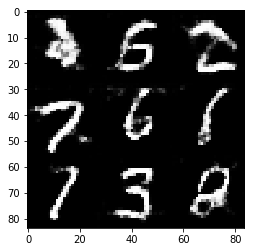

Step: 2110: Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.4906
Step: 2120: Epoch 2/2... Discriminator Loss: 0.3797... Generator Loss: 4.7824
Step: 2130: Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 1.0001
Step: 2140: Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.7242
Step: 2150: Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.2551
Step: 2160: Epoch 2/2... Discriminator Loss: 0.4755... Generator Loss: 2.3345
Step: 2170: Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.3541
Step: 2180: Epoch 2/2... Discriminator Loss: 2.0658... Generator Loss: 0.2637
Step: 2190: Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.2864
Step: 2200: Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 0.4850


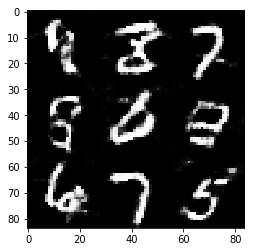

Step: 2210: Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.0497
Step: 2220: Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 6.6336
Step: 2230: Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.6366
Step: 2240: Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.6578
Step: 2250: Epoch 2/2... Discriminator Loss: 1.9291... Generator Loss: 0.3185
Step: 2260: Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 1.6541
Step: 2270: Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 2.3039
Step: 2280: Epoch 2/2... Discriminator Loss: 0.9038... Generator Loss: 1.1244
Step: 2290: Epoch 2/2... Discriminator Loss: 0.5247... Generator Loss: 2.2413
Step: 2300: Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.6809


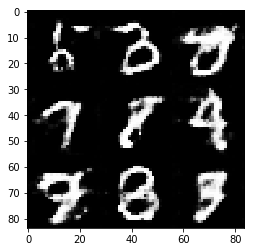

Step: 2310: Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.7781
Step: 2320: Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.2977
Step: 2330: Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8022
Step: 2340: Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.4618
Step: 2350: Epoch 2/2... Discriminator Loss: 1.6130... Generator Loss: 0.5142
Step: 2360: Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 0.8477
Step: 2370: Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.9217
Step: 2380: Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 0.8967
Step: 2390: Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.1067
Step: 2400: Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.8340


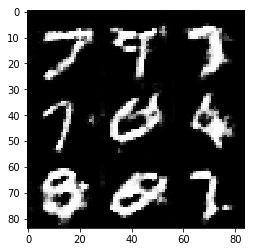

Step: 2410: Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 2.0845
Step: 2420: Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.4071
Step: 2430: Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 1.8574
Step: 2440: Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.3242
Step: 2450: Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.7209
Step: 2460: Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 1.0489
Step: 2470: Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.6474
Step: 2480: Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.5156
Step: 2490: Epoch 2/2... Discriminator Loss: 0.6279... Generator Loss: 1.5754
Step: 2500: Epoch 2/2... Discriminator Loss: 1.8025... Generator Loss: 0.3313


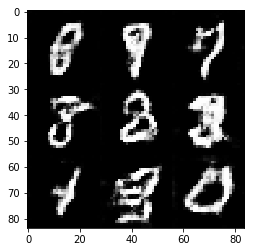

Step: 2510: Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.1471
Step: 2520: Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.5210
Step: 2530: Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.8285
Step: 2540: Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.2943
Step: 2550: Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 0.7601
Step: 2560: Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.5446
Step: 2570: Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.7981
Step: 2580: Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.6269
Step: 2590: Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.4273
Step: 2600: Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.5150


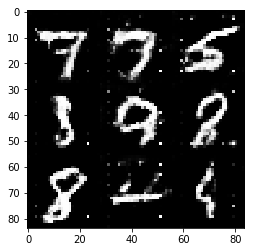

Step: 2610: Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.4158
Step: 2620: Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.2139
Step: 2630: Epoch 2/2... Discriminator Loss: 2.9337... Generator Loss: 0.1248
Step: 2640: Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.4878
Step: 2650: Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.7625
Step: 2660: Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 1.3684
Step: 2670: Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.8289
Step: 2680: Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.1853
Step: 2690: Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 7.5414
Step: 2700: Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.6062


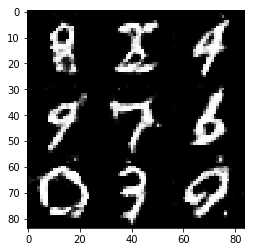

Step: 2710: Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.3704
Step: 2720: Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 1.7208
Step: 2730: Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.4486
Step: 2740: Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.5350
Step: 2750: Epoch 2/2... Discriminator Loss: 0.3500... Generator Loss: 5.6783
Step: 2760: Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.7277
Step: 2770: Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 2.5945
Step: 2780: Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.2279
Step: 2790: Epoch 2/2... Discriminator Loss: 0.7462... Generator Loss: 1.2142
Step: 2800: Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.6125


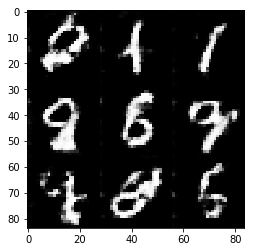

Step: 2810: Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.6040
Step: 2820: Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.5006
Step: 2830: Epoch 2/2... Discriminator Loss: 2.5213... Generator Loss: 0.2134
Step: 2840: Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 2.6140
Step: 2850: Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 1.0178
Step: 2860: Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.8133
Step: 2870: Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.7273
Step: 2880: Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.0379
Step: 2890: Epoch 2/2... Discriminator Loss: 1.8645... Generator Loss: 0.3012
Step: 2900: Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.7192


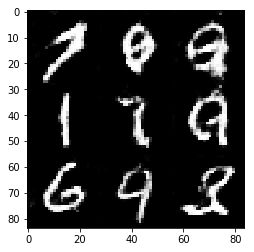

Step: 2910: Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 1.9976
Step: 2920: Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 1.0744
Step: 2930: Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 1.7530
Step: 2940: Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.5751
Step: 2950: Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.6193
Step: 2960: Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.4999
Step: 2970: Epoch 2/2... Discriminator Loss: 1.7340... Generator Loss: 0.3915
Step: 2980: Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 4.0592
Step: 2990: Epoch 2/2... Discriminator Loss: 2.4418... Generator Loss: 0.2170
Step: 3000: Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.6733


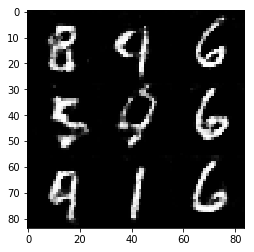

Step: 3010: Epoch 2/2... Discriminator Loss: 2.4224... Generator Loss: 0.2365
Step: 3020: Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 7.1085
Step: 3030: Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.4844
Step: 3040: Epoch 2/2... Discriminator Loss: 1.4986... Generator Loss: 0.4527
Step: 3050: Epoch 2/2... Discriminator Loss: 0.5353... Generator Loss: 7.7507
Step: 3060: Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 2.0871
Step: 3070: Epoch 2/2... Discriminator Loss: 1.5251... Generator Loss: 0.4963
Step: 3080: Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.6264
Step: 3090: Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.6557
Step: 3100: Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.0790


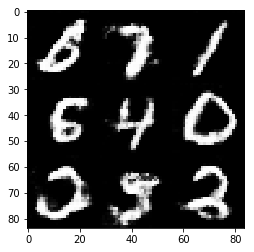

Step: 3110: Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.1998
Step: 3120: Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.9431
Step: 3130: Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 1.4650
Step: 3140: Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.7283
Step: 3150: Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 1.0084
Step: 3160: Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.5400
Step: 3170: Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 1.1067
Step: 3180: Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.7706
Step: 3190: Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.9317
Step: 3200: Epoch 2/2... Discriminator Loss: 0.5861... Generator Loss: 1.9032


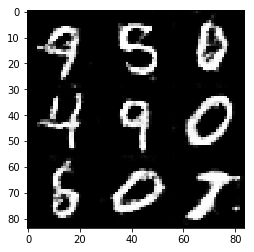

Step: 3210: Epoch 2/2... Discriminator Loss: 2.4843... Generator Loss: 0.1898
Step: 3220: Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.9319
Step: 3230: Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.5384
Step: 3240: Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.7041
Step: 3250: Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.5031
Step: 3260: Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 0.9576
Step: 3270: Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.4905
Step: 3280: Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.5071
Step: 3290: Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.8009
Step: 3300: Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.9911


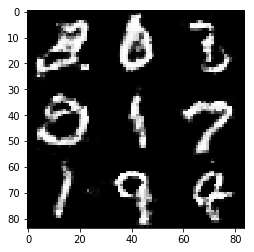

Step: 3310: Epoch 2/2... Discriminator Loss: 1.7152... Generator Loss: 0.3524
Step: 3320: Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.8612
Step: 3330: Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 0.5192
Step: 3340: Epoch 2/2... Discriminator Loss: 2.2046... Generator Loss: 0.2257
Step: 3350: Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.6524
Step: 3360: Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.0879
Step: 3370: Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.0167
Step: 3380: Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.7089
Step: 3390: Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 0.4410
Step: 3400: Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 1.3099


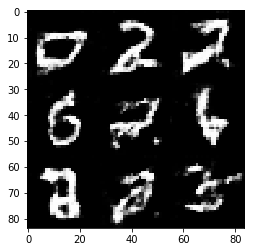

Step: 3410: Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.6678
Step: 3420: Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7528
Step: 3430: Epoch 2/2... Discriminator Loss: 0.4342... Generator Loss: 6.7874
Step: 3440: Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.2047
Step: 3450: Epoch 2/2... Discriminator Loss: 0.7231... Generator Loss: 1.3334
Step: 3460: Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.1844
Step: 3470: Epoch 2/2... Discriminator Loss: 1.4700... Generator Loss: 0.4834
Step: 3480: Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.2338
Step: 3490: Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.3875
Step: 3500: Epoch 2/2... Discriminator Loss: 0.5976... Generator Loss: 1.7079


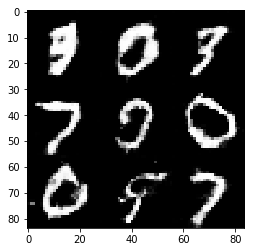

Step: 3510: Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.6856
Step: 3520: Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.2820
Step: 3530: Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.1871
Step: 3540: Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 0.9693
Step: 3550: Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 1.5165
Step: 3560: Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.8072
Step: 3570: Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.5354
Step: 3580: Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 4.0620
Step: 3590: Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 3.4965
Step: 3600: Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.7961


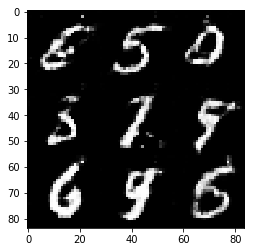

Step: 3610: Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.1326
Step: 3620: Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 0.9664
Step: 3630: Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.5922
Step: 3640: Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.6071
Step: 3650: Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.9373
Step: 3660: Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 0.7914
Step: 3670: Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.6386
Step: 3680: Epoch 2/2... Discriminator Loss: 0.8072... Generator Loss: 1.1337
Step: 3690: Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 0.6517
Step: 3700: Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.0898


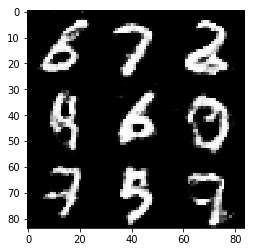

Step: 3710: Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.2463
Step: 3720: Epoch 2/2... Discriminator Loss: 0.3878... Generator Loss: 4.6214
Step: 3730: Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.5910
Step: 3740: Epoch 2/2... Discriminator Loss: 0.5847... Generator Loss: 1.6760
Step: 3750: Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 0.8320
Finished the training


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting the training
Step: 10: Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.7322
Step: 20: Epoch 1/1... Discriminator Loss: 1.7230... Generator Loss: 0.8360
Step: 30: Epoch 1/1... Discriminator Loss: 2.3663... Generator Loss: 0.5451
Step: 40: Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.3769
Step: 50: Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6216
Step: 60: Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 1.8426
Step: 70: Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8750
Step: 80: Epoch 1/1... Discriminator Loss: 2.3196... Generator Loss: 0.6241
Step: 90: Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.5562
Step: 100: Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.7846


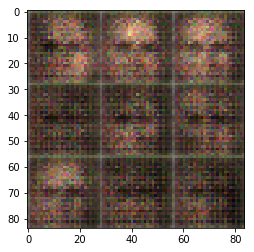

Step: 110: Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 3.2171
Step: 120: Epoch 1/1... Discriminator Loss: 2.0619... Generator Loss: 0.6234
Step: 130: Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 3.4429
Step: 140: Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 1.9404
Step: 150: Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 5.7985
Step: 160: Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.7415
Step: 170: Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.7535
Step: 180: Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.3722
Step: 190: Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 4.2322
Step: 200: Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.5986


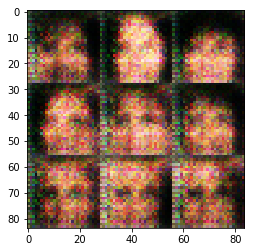

Step: 210: Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 3.8555
Step: 220: Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6266
Step: 230: Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.1389
Step: 240: Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.7799
Step: 250: Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9427
Step: 260: Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 1.9627
Step: 270: Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.9090
Step: 280: Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 4.0029
Step: 290: Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 4.5710
Step: 300: Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.9053


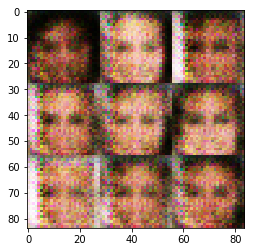

Step: 310: Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.8934
Step: 320: Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.5318
Step: 330: Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 3.0377
Step: 340: Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 0.7792
Step: 350: Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.2925
Step: 360: Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 5.0473
Step: 370: Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.1976
Step: 380: Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7969
Step: 390: Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 4.8459
Step: 400: Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 3.9198


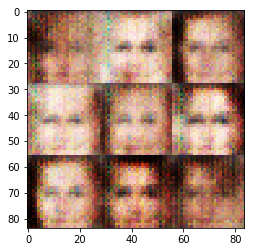

Step: 410: Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.8601
Step: 420: Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 6.4829
Step: 430: Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.8955
Step: 440: Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7553
Step: 450: Epoch 1/1... Discriminator Loss: 2.1364... Generator Loss: 8.5073
Step: 460: Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.9337
Step: 470: Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 6.1495
Step: 480: Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.3799
Step: 490: Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.8171
Step: 500: Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 7.5286


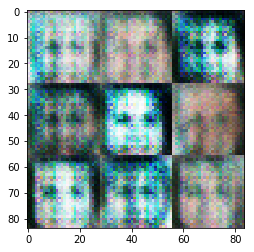

Step: 510: Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.5108
Step: 520: Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 2.0797
Step: 530: Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.9838
Step: 540: Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.5455
Step: 550: Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.3974
Step: 560: Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.2212
Step: 570: Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.9163
Step: 580: Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.7326
Step: 590: Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.7320
Step: 600: Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 1.0669


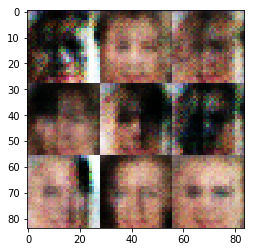

Step: 610: Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.3357
Step: 620: Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 6.8472
Step: 630: Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.2045
Step: 640: Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.4064
Step: 650: Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.0139
Step: 660: Epoch 1/1... Discriminator Loss: 3.8225... Generator Loss: 0.0860
Step: 670: Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 2.2778
Step: 680: Epoch 1/1... Discriminator Loss: 2.0056... Generator Loss: 0.5240
Step: 690: Epoch 1/1... Discriminator Loss: 2.9539... Generator Loss: 0.1362
Step: 700: Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.1545


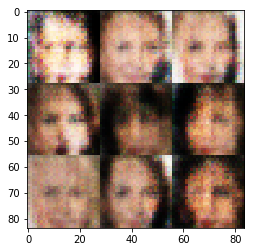

Step: 710: Epoch 1/1... Discriminator Loss: 3.1485... Generator Loss: 0.1256
Step: 720: Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.0001
Step: 730: Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 4.0701
Step: 740: Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 5.6158
Step: 750: Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.8566
Step: 760: Epoch 1/1... Discriminator Loss: 1.7029... Generator Loss: 0.5078
Step: 770: Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.6833
Step: 780: Epoch 1/1... Discriminator Loss: 1.8386... Generator Loss: 6.9923
Step: 790: Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 3.2764
Step: 800: Epoch 1/1... Discriminator Loss: 2.6919... Generator Loss: 0.1583


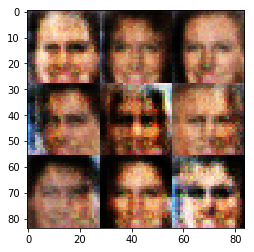

Step: 810: Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.2550
Step: 820: Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.5002
Step: 830: Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.3161
Step: 840: Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 2.5744
Step: 850: Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.2355
Step: 860: Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 8.1766
Step: 870: Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.4494
Step: 880: Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.1770
Step: 890: Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.2100
Step: 900: Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9374


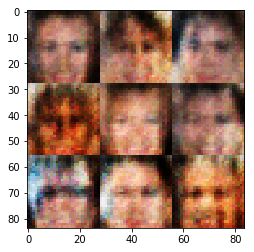

Step: 910: Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5828
Step: 920: Epoch 1/1... Discriminator Loss: 2.4546... Generator Loss: 0.2229
Step: 930: Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.4828
Step: 940: Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 1.5261
Step: 950: Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.0235
Step: 960: Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.1966
Step: 970: Epoch 1/1... Discriminator Loss: 3.3112... Generator Loss: 0.1105
Step: 980: Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.7628
Step: 990: Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.3678
Step: 1000: Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.1895


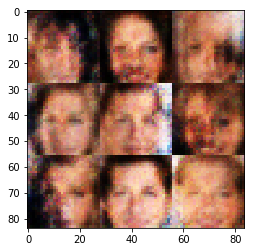

Step: 1010: Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0963
Step: 1020: Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.4968
Step: 1030: Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.8730
Step: 1040: Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7661
Step: 1050: Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.2062
Step: 1060: Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.3839
Step: 1070: Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 3.0219
Step: 1080: Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.4552
Step: 1090: Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.4249
Step: 1100: Epoch 1/1... Discriminator Loss: 2.5883... Generator Loss: 10.1939


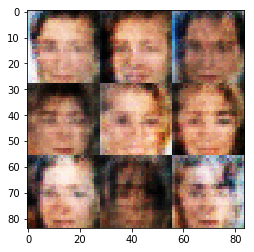

Step: 1110: Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.3188
Step: 1120: Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.7220
Step: 1130: Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.1473
Step: 1140: Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 3.3648
Step: 1150: Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7948
Step: 1160: Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 6.6742
Step: 1170: Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.4863
Step: 1180: Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.2908
Step: 1190: Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 5.0530
Step: 1200: Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6648


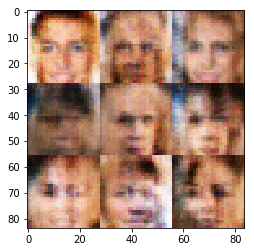

Step: 1210: Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.8384
Step: 1220: Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5896
Step: 1230: Epoch 1/1... Discriminator Loss: 2.5216... Generator Loss: 0.1807
Step: 1240: Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 4.0272
Step: 1250: Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.1560
Step: 1260: Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.6427
Step: 1270: Epoch 1/1... Discriminator Loss: 1.7283... Generator Loss: 0.7204
Step: 1280: Epoch 1/1... Discriminator Loss: 2.8108... Generator Loss: 0.2070
Step: 1290: Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.1508
Step: 1300: Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 5.8594


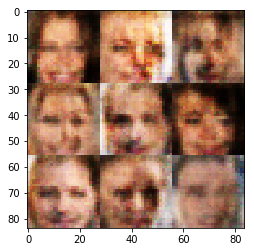

Step: 1310: Epoch 1/1... Discriminator Loss: 2.8568... Generator Loss: 0.1269
Step: 1320: Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.3435
Step: 1330: Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 6.2473
Step: 1340: Epoch 1/1... Discriminator Loss: 2.8001... Generator Loss: 0.2010
Step: 1350: Epoch 1/1... Discriminator Loss: 2.5769... Generator Loss: 0.1654
Step: 1360: Epoch 1/1... Discriminator Loss: 2.3158... Generator Loss: 0.2671
Step: 1370: Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6992
Step: 1380: Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.1692
Step: 1390: Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 2.1836
Step: 1400: Epoch 1/1... Discriminator Loss: 2.7394... Generator Loss: 0.1424


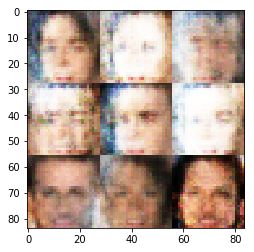

Step: 1410: Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8001
Step: 1420: Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5251
Step: 1430: Epoch 1/1... Discriminator Loss: 2.3303... Generator Loss: 0.1994
Step: 1440: Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 3.8698
Step: 1450: Epoch 1/1... Discriminator Loss: 3.2043... Generator Loss: 0.0934
Step: 1460: Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 5.1372
Step: 1470: Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.4487
Step: 1480: Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.5321
Step: 1490: Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.4095
Step: 1500: Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.4312


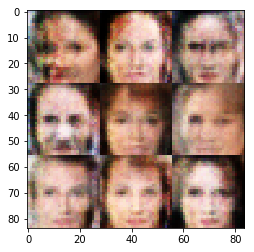

Step: 1510: Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.6866
Step: 1520: Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 4.7378
Step: 1530: Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6691
Step: 1540: Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 7.1757
Step: 1550: Epoch 1/1... Discriminator Loss: 2.3923... Generator Loss: 0.2123
Step: 1560: Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.9278
Step: 1570: Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.3852
Step: 1580: Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.1895
Step: 1590: Epoch 1/1... Discriminator Loss: 2.6450... Generator Loss: 0.1976
Step: 1600: Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.8801


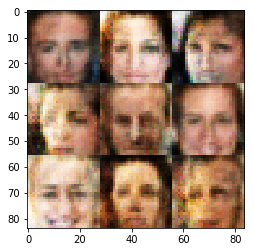

Step: 1610: Epoch 1/1... Discriminator Loss: 3.2262... Generator Loss: 0.0988
Step: 1620: Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6137
Step: 1630: Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.4086
Step: 1640: Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 7.1133
Step: 1650: Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 4.7037
Step: 1660: Epoch 1/1... Discriminator Loss: 2.1747... Generator Loss: 0.3390
Step: 1670: Epoch 1/1... Discriminator Loss: 2.7307... Generator Loss: 0.1612
Step: 1680: Epoch 1/1... Discriminator Loss: 2.6207... Generator Loss: 0.1384
Step: 1690: Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5613
Step: 1700: Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.4261


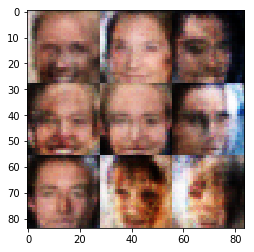

Step: 1710: Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7000
Step: 1720: Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5291
Step: 1730: Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8555
Step: 1740: Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.0144
Step: 1750: Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.5064
Step: 1760: Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 4.1518
Step: 1770: Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.9038
Step: 1780: Epoch 1/1... Discriminator Loss: 2.1666... Generator Loss: 0.2951
Step: 1790: Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.9113
Step: 1800: Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.6464


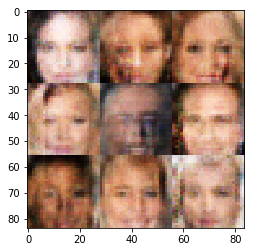

Step: 1810: Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5226
Step: 1820: Epoch 1/1... Discriminator Loss: 2.2146... Generator Loss: 0.2371
Step: 1830: Epoch 1/1... Discriminator Loss: 2.7807... Generator Loss: 0.1395
Step: 1840: Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.9248
Step: 1850: Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.7121
Step: 1860: Epoch 1/1... Discriminator Loss: 2.0164... Generator Loss: 0.2393
Step: 1870: Epoch 1/1... Discriminator Loss: 3.1806... Generator Loss: 0.0990
Step: 1880: Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.8569
Step: 1890: Epoch 1/1... Discriminator Loss: 2.2342... Generator Loss: 0.3332
Step: 1900: Epoch 1/1... Discriminator Loss: 1.9642... Generator Loss: 0.3258


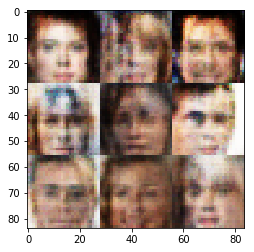

Step: 1910: Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6118
Step: 1920: Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7062
Step: 1930: Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.4374
Step: 1940: Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 2.9005
Step: 1950: Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 7.1451
Step: 1960: Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.3829
Step: 1970: Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.5455
Step: 1980: Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6407
Step: 1990: Epoch 1/1... Discriminator Loss: 3.6299... Generator Loss: 0.0787
Step: 2000: Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.7862


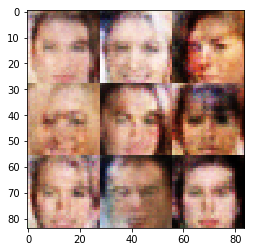

Step: 2010: Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7020
Step: 2020: Epoch 1/1... Discriminator Loss: 2.5054... Generator Loss: 0.1800
Step: 2030: Epoch 1/1... Discriminator Loss: 2.2481... Generator Loss: 0.2610
Step: 2040: Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.7370
Step: 2050: Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.4786
Step: 2060: Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.0991
Step: 2070: Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8361
Step: 2080: Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6749
Step: 2090: Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.3850
Step: 2100: Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4856


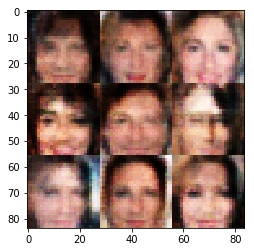

Step: 2110: Epoch 1/1... Discriminator Loss: 2.2557... Generator Loss: 0.2190
Step: 2120: Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.1936
Step: 2130: Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.4204
Step: 2140: Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.8313
Step: 2150: Epoch 1/1... Discriminator Loss: 2.0315... Generator Loss: 0.3717
Step: 2160: Epoch 1/1... Discriminator Loss: 3.3014... Generator Loss: 0.0731
Step: 2170: Epoch 1/1... Discriminator Loss: 1.8449... Generator Loss: 0.3065
Step: 2180: Epoch 1/1... Discriminator Loss: 2.2623... Generator Loss: 0.2016
Step: 2190: Epoch 1/1... Discriminator Loss: 3.9319... Generator Loss: 0.0572
Step: 2200: Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6324


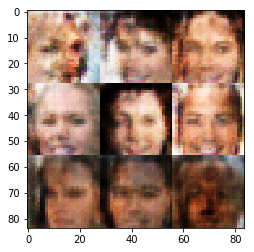

Step: 2210: Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.8508
Step: 2220: Epoch 1/1... Discriminator Loss: 3.4365... Generator Loss: 0.0803
Step: 2230: Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 3.7102
Step: 2240: Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.5293
Step: 2250: Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8015
Step: 2260: Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.7818
Step: 2270: Epoch 1/1... Discriminator Loss: 3.2127... Generator Loss: 0.0953
Step: 2280: Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 5.2253
Step: 2290: Epoch 1/1... Discriminator Loss: 2.0663... Generator Loss: 0.2460
Step: 2300: Epoch 1/1... Discriminator Loss: 2.3427... Generator Loss: 0.1877


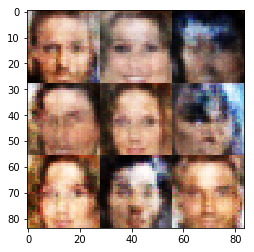

Step: 2310: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5400
Step: 2320: Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.7083
Step: 2330: Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.4215
Step: 2340: Epoch 1/1... Discriminator Loss: 2.5262... Generator Loss: 0.1624
Step: 2350: Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.3465
Step: 2360: Epoch 1/1... Discriminator Loss: 2.0152... Generator Loss: 0.2631
Step: 2370: Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6151
Step: 2380: Epoch 1/1... Discriminator Loss: 3.7972... Generator Loss: 0.0632
Step: 2390: Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 2.0808
Step: 2400: Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7356


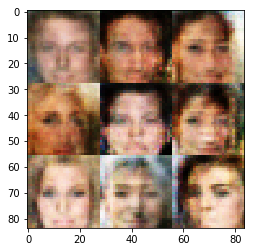

Step: 2410: Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7456
Step: 2420: Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.6980
Step: 2430: Epoch 1/1... Discriminator Loss: 2.4362... Generator Loss: 0.1995
Step: 2440: Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6845
Step: 2450: Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.3567
Step: 2460: Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 7.9037
Step: 2470: Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4648
Step: 2480: Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 3.0913
Step: 2490: Epoch 1/1... Discriminator Loss: 3.1360... Generator Loss: 0.0810
Step: 2500: Epoch 1/1... Discriminator Loss: 3.1805... Generator Loss: 0.0970


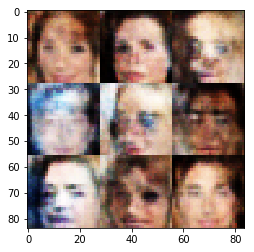

Step: 2510: Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 4.6075
Step: 2520: Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.2799
Step: 2530: Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.5460
Step: 2540: Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5221
Step: 2550: Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6674
Step: 2560: Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.4644
Step: 2570: Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4688
Step: 2580: Epoch 1/1... Discriminator Loss: 1.8625... Generator Loss: 0.3595
Step: 2590: Epoch 1/1... Discriminator Loss: 2.2879... Generator Loss: 0.2553
Step: 2600: Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.8854


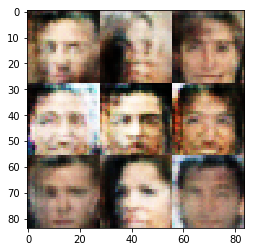

Step: 2610: Epoch 1/1... Discriminator Loss: 2.9506... Generator Loss: 0.1116
Step: 2620: Epoch 1/1... Discriminator Loss: 2.9416... Generator Loss: 0.1220
Step: 2630: Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.8086
Step: 2640: Epoch 1/1... Discriminator Loss: 2.7138... Generator Loss: 0.1233
Step: 2650: Epoch 1/1... Discriminator Loss: 1.9050... Generator Loss: 0.3260
Step: 2660: Epoch 1/1... Discriminator Loss: 2.8561... Generator Loss: 0.1243
Step: 2670: Epoch 1/1... Discriminator Loss: 2.9118... Generator Loss: 0.1284
Step: 2680: Epoch 1/1... Discriminator Loss: 3.7246... Generator Loss: 0.0602
Step: 2690: Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9696
Step: 2700: Epoch 1/1... Discriminator Loss: 2.6935... Generator Loss: 0.2116


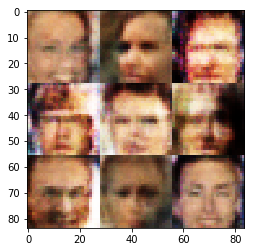

Step: 2710: Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 2.5219
Step: 2720: Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.3850
Step: 2730: Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.5982
Step: 2740: Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.5806
Step: 2750: Epoch 1/1... Discriminator Loss: 2.1295... Generator Loss: 0.2062
Step: 2760: Epoch 1/1... Discriminator Loss: 2.9195... Generator Loss: 0.1264
Step: 2770: Epoch 1/1... Discriminator Loss: 3.2410... Generator Loss: 0.0971
Step: 2780: Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 8.9051
Step: 2790: Epoch 1/1... Discriminator Loss: 2.3102... Generator Loss: 0.2169
Step: 2800: Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5328


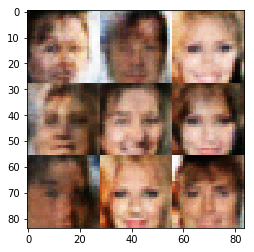

Step: 2810: Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.4439
Step: 2820: Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 8.7998
Step: 2830: Epoch 1/1... Discriminator Loss: 3.0340... Generator Loss: 0.1133
Step: 2840: Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.3748
Step: 2850: Epoch 1/1... Discriminator Loss: 2.6384... Generator Loss: 0.1632
Step: 2860: Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.7763
Step: 2870: Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.4322
Step: 2880: Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.4617
Step: 2890: Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9856
Step: 2900: Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.7130


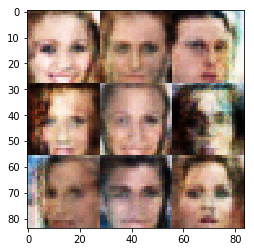

Step: 2910: Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.9608
Step: 2920: Epoch 1/1... Discriminator Loss: 2.3420... Generator Loss: 0.2096
Step: 2930: Epoch 1/1... Discriminator Loss: 2.6017... Generator Loss: 0.1802
Step: 2940: Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.2977
Step: 2950: Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.1984
Step: 2960: Epoch 1/1... Discriminator Loss: 2.3580... Generator Loss: 0.1772
Step: 2970: Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.8698
Step: 2980: Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 4.5704
Step: 2990: Epoch 1/1... Discriminator Loss: 2.7201... Generator Loss: 0.1508
Step: 3000: Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 2.3812


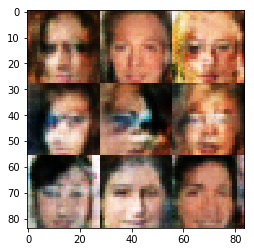

Step: 3010: Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8833
Step: 3020: Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 0.3834
Step: 3030: Epoch 1/1... Discriminator Loss: 0.5172... Generator Loss: 2.9990
Step: 3040: Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.6921
Step: 3050: Epoch 1/1... Discriminator Loss: 2.7159... Generator Loss: 0.1987
Step: 3060: Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 0.9403
Step: 3070: Epoch 1/1... Discriminator Loss: 1.7996... Generator Loss: 0.3199
Step: 3080: Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.8575
Step: 3090: Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.4525
Step: 3100: Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.8569


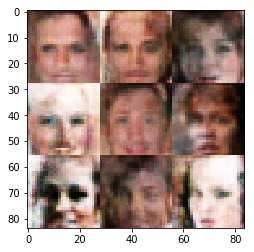

Step: 3110: Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9066
Step: 3120: Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.8716
Step: 3130: Epoch 1/1... Discriminator Loss: 2.7117... Generator Loss: 0.1531
Step: 3140: Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.9014
Step: 3150: Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.3263
Step: 3160: Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5601
Step: 3170: Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.4325
Step: 3180: Epoch 1/1... Discriminator Loss: 2.0000... Generator Loss: 0.2744
Step: 3190: Epoch 1/1... Discriminator Loss: 3.2066... Generator Loss: 0.1101
Step: 3200: Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.3386


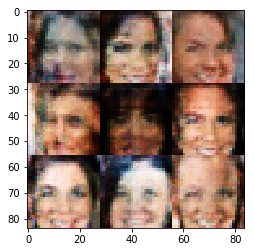

Step: 3210: Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5973
Step: 3220: Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8257
Step: 3230: Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.2511
Step: 3240: Epoch 1/1... Discriminator Loss: 1.9479... Generator Loss: 0.2676
Step: 3250: Epoch 1/1... Discriminator Loss: 2.3948... Generator Loss: 0.1741
Step: 3260: Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 4.7477
Step: 3270: Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4262
Step: 3280: Epoch 1/1... Discriminator Loss: 2.3673... Generator Loss: 0.1667
Step: 3290: Epoch 1/1... Discriminator Loss: 3.4509... Generator Loss: 0.0836
Step: 3300: Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4992


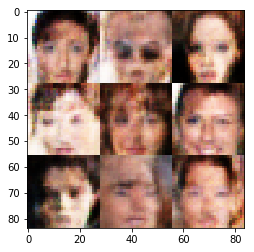

Step: 3310: Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7917
Step: 3320: Epoch 1/1... Discriminator Loss: 2.7314... Generator Loss: 0.1450
Step: 3330: Epoch 1/1... Discriminator Loss: 3.0004... Generator Loss: 0.1643
Step: 3340: Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6846
Step: 3350: Epoch 1/1... Discriminator Loss: 2.6589... Generator Loss: 0.1280
Step: 3360: Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.4794
Step: 3370: Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5580
Step: 3380: Epoch 1/1... Discriminator Loss: 2.0676... Generator Loss: 0.2362
Step: 3390: Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.4200
Step: 3400: Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7065


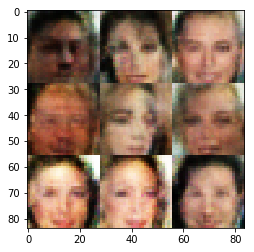

Step: 3410: Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.5540
Step: 3420: Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 5.6639
Step: 3430: Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6631
Step: 3440: Epoch 1/1... Discriminator Loss: 3.2111... Generator Loss: 0.0881
Step: 3450: Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.6082
Step: 3460: Epoch 1/1... Discriminator Loss: 2.2375... Generator Loss: 0.1888
Step: 3470: Epoch 1/1... Discriminator Loss: 3.5542... Generator Loss: 0.0765
Step: 3480: Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5372
Step: 3490: Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.4539
Step: 3500: Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.7455


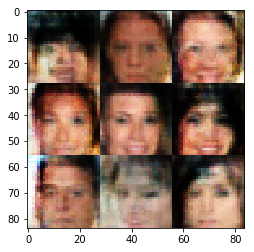

Step: 3510: Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.8507
Step: 3520: Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.4929
Step: 3530: Epoch 1/1... Discriminator Loss: 1.8806... Generator Loss: 0.3420
Step: 3540: Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 0.9312
Step: 3550: Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0893
Step: 3560: Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5772
Step: 3570: Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.4837
Step: 3580: Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.4934
Step: 3590: Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 1.7397
Step: 3600: Epoch 1/1... Discriminator Loss: 2.0838... Generator Loss: 0.3267


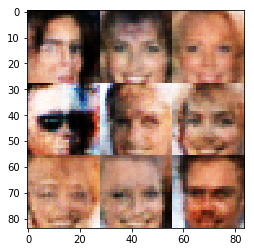

Step: 3610: Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.4949
Step: 3620: Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8206
Step: 3630: Epoch 1/1... Discriminator Loss: 2.7890... Generator Loss: 0.1382
Step: 3640: Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.5108
Step: 3650: Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.4316
Step: 3660: Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.0986
Step: 3670: Epoch 1/1... Discriminator Loss: 1.7140... Generator Loss: 0.4003
Step: 3680: Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.5375
Step: 3690: Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.0215
Step: 3700: Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 4.1558


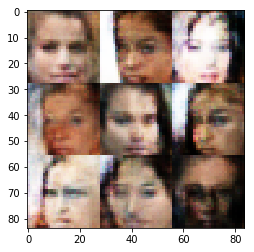

Step: 3710: Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.4481
Step: 3720: Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.4147
Step: 3730: Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.3727
Step: 3740: Epoch 1/1... Discriminator Loss: 2.7619... Generator Loss: 0.1433
Step: 3750: Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.7509
Step: 3760: Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.0909
Step: 3770: Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.5716
Step: 3780: Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9479
Step: 3790: Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.4723
Step: 3800: Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6862


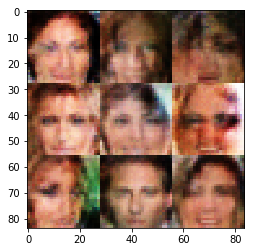

Step: 3810: Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.0574
Step: 3820: Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.4453
Step: 3830: Epoch 1/1... Discriminator Loss: 3.6658... Generator Loss: 0.0655
Step: 3840: Epoch 1/1... Discriminator Loss: 2.4748... Generator Loss: 0.1819
Step: 3850: Epoch 1/1... Discriminator Loss: 3.0495... Generator Loss: 0.1443
Step: 3860: Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.4929
Step: 3870: Epoch 1/1... Discriminator Loss: 2.3642... Generator Loss: 0.1943
Step: 3880: Epoch 1/1... Discriminator Loss: 2.1484... Generator Loss: 0.2368
Step: 3890: Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.8284
Step: 3900: Epoch 1/1... Discriminator Loss: 2.5256... Generator Loss: 0.1783


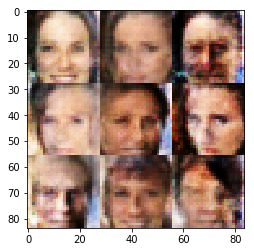

Step: 3910: Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.2926
Step: 3920: Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6959
Step: 3930: Epoch 1/1... Discriminator Loss: 1.9943... Generator Loss: 8.9684
Step: 3940: Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.4357
Step: 3950: Epoch 1/1... Discriminator Loss: 1.9838... Generator Loss: 0.3426
Step: 3960: Epoch 1/1... Discriminator Loss: 1.9917... Generator Loss: 0.2889
Step: 3970: Epoch 1/1... Discriminator Loss: 2.3439... Generator Loss: 0.2329
Step: 3980: Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5191
Step: 3990: Epoch 1/1... Discriminator Loss: 3.2287... Generator Loss: 0.0868
Step: 4000: Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 8.7140


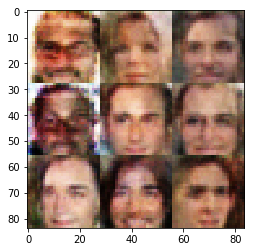

Step: 4010: Epoch 1/1... Discriminator Loss: 3.4445... Generator Loss: 0.0896
Step: 4020: Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7336
Step: 4030: Epoch 1/1... Discriminator Loss: 2.6081... Generator Loss: 0.1846
Step: 4040: Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.2249
Step: 4050: Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 1.5496
Step: 4060: Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5863
Step: 4070: Epoch 1/1... Discriminator Loss: 2.2917... Generator Loss: 0.1914
Step: 4080: Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.4994
Step: 4090: Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 6.3748
Step: 4100: Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.5125


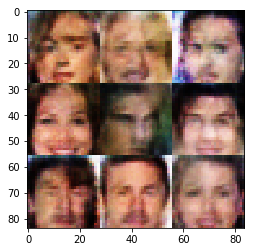

Step: 4110: Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4411
Step: 4120: Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5482
Step: 4130: Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4711
Step: 4140: Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.0162
Step: 4150: Epoch 1/1... Discriminator Loss: 2.9768... Generator Loss: 0.1513
Step: 4160: Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.3370
Step: 4170: Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.3032
Step: 4180: Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 4.2836
Step: 4190: Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.8015
Step: 4200: Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.0193


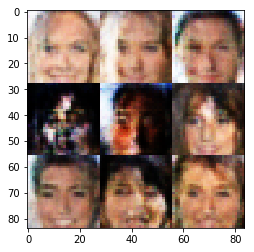

Step: 4210: Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6770
Step: 4220: Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7703
Step: 4230: Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6040
Step: 4240: Epoch 1/1... Discriminator Loss: 3.1676... Generator Loss: 0.0975
Step: 4250: Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.4225
Step: 4260: Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5231
Step: 4270: Epoch 1/1... Discriminator Loss: 2.1260... Generator Loss: 0.2428
Step: 4280: Epoch 1/1... Discriminator Loss: 2.0645... Generator Loss: 0.2260
Step: 4290: Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 4.2689
Step: 4300: Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.4314


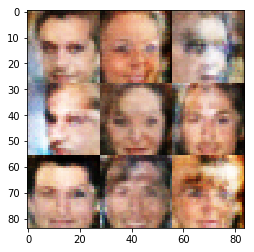

Step: 4310: Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.3191
Step: 4320: Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.4732
Step: 4330: Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.3643
Step: 4340: Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.6093
Step: 4350: Epoch 1/1... Discriminator Loss: 1.9475... Generator Loss: 0.3074
Step: 4360: Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 2.5941
Step: 4370: Epoch 1/1... Discriminator Loss: 1.9662... Generator Loss: 0.3273
Step: 4380: Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.5578
Step: 4390: Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.1457
Step: 4400: Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5817


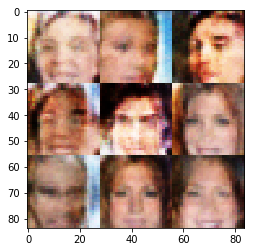

Step: 4410: Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.6454
Step: 4420: Epoch 1/1... Discriminator Loss: 2.4271... Generator Loss: 0.1840
Step: 4430: Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.6041
Step: 4440: Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8621
Step: 4450: Epoch 1/1... Discriminator Loss: 2.3798... Generator Loss: 0.1941
Step: 4460: Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.6972
Step: 4470: Epoch 1/1... Discriminator Loss: 2.2738... Generator Loss: 0.2018
Step: 4480: Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8670
Step: 4490: Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.4895
Step: 4500: Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 6.8297


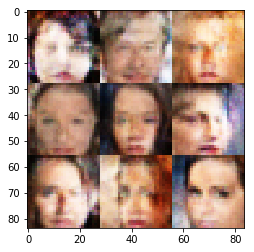

Step: 4510: Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.4064
Step: 4520: Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6437
Step: 4530: Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.4962
Step: 4540: Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.2966
Step: 4550: Epoch 1/1... Discriminator Loss: 2.0290... Generator Loss: 0.2193
Step: 4560: Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.4636
Step: 4570: Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 7.7523
Step: 4580: Epoch 1/1... Discriminator Loss: 2.5769... Generator Loss: 0.1813
Step: 4590: Epoch 1/1... Discriminator Loss: 2.4659... Generator Loss: 0.1906
Step: 4600: Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.8388


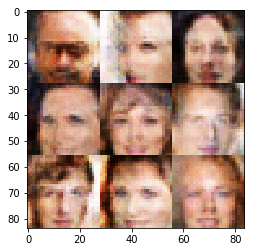

Step: 4610: Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6663
Step: 4620: Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.2713
Step: 4630: Epoch 1/1... Discriminator Loss: 2.5821... Generator Loss: 0.1646
Step: 4640: Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.5310
Step: 4650: Epoch 1/1... Discriminator Loss: 3.0517... Generator Loss: 0.1186
Step: 4660: Epoch 1/1... Discriminator Loss: 2.8789... Generator Loss: 0.1300
Step: 4670: Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4562
Step: 4680: Epoch 1/1... Discriminator Loss: 2.2248... Generator Loss: 0.2557
Step: 4690: Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 9.0439
Step: 4700: Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.9413


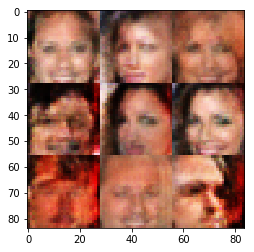

Step: 4710: Epoch 1/1... Discriminator Loss: 2.4820... Generator Loss: 0.1772
Step: 4720: Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.3743
Step: 4730: Epoch 1/1... Discriminator Loss: 2.0818... Generator Loss: 0.2868
Step: 4740: Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 3.0795
Step: 4750: Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6616
Step: 4760: Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8378
Step: 4770: Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5180
Step: 4780: Epoch 1/1... Discriminator Loss: 2.2386... Generator Loss: 0.2113
Step: 4790: Epoch 1/1... Discriminator Loss: 1.8150... Generator Loss: 0.3563
Step: 4800: Epoch 1/1... Discriminator Loss: 2.1794... Generator Loss: 0.2579


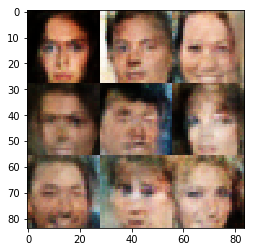

Step: 4810: Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6458
Step: 4820: Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.1925
Step: 4830: Epoch 1/1... Discriminator Loss: 2.6604... Generator Loss: 0.1658
Step: 4840: Epoch 1/1... Discriminator Loss: 2.5170... Generator Loss: 0.2571
Step: 4850: Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.4238
Step: 4860: Epoch 1/1... Discriminator Loss: 2.4132... Generator Loss: 0.2363
Step: 4870: Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.2994
Step: 4880: Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 2.0877
Step: 4890: Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.4247
Step: 4900: Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.9878


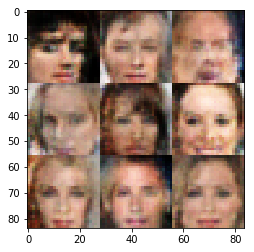

Step: 4910: Epoch 1/1... Discriminator Loss: 1.9029... Generator Loss: 0.3103
Step: 4920: Epoch 1/1... Discriminator Loss: 4.0984... Generator Loss: 0.0472
Step: 4930: Epoch 1/1... Discriminator Loss: 2.0190... Generator Loss: 0.2533
Step: 4940: Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.9314
Step: 4950: Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.4321
Step: 4960: Epoch 1/1... Discriminator Loss: 2.7230... Generator Loss: 0.1731
Step: 4970: Epoch 1/1... Discriminator Loss: 2.6657... Generator Loss: 0.1437
Step: 4980: Epoch 1/1... Discriminator Loss: 2.5148... Generator Loss: 0.1501
Step: 4990: Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 5.7849
Step: 5000: Epoch 1/1... Discriminator Loss: 2.9937... Generator Loss: 0.1400


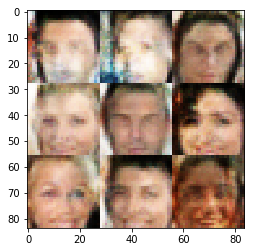

Step: 5010: Epoch 1/1... Discriminator Loss: 1.7524... Generator Loss: 0.3674
Step: 5020: Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 2.4770
Step: 5030: Epoch 1/1... Discriminator Loss: 2.1087... Generator Loss: 0.2026
Step: 5040: Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.9541
Step: 5050: Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6216
Step: 5060: Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7521
Step: 5070: Epoch 1/1... Discriminator Loss: 1.6773... Generator Loss: 0.3625
Step: 5080: Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 5.2994
Step: 5090: Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.7511
Step: 5100: Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.4200


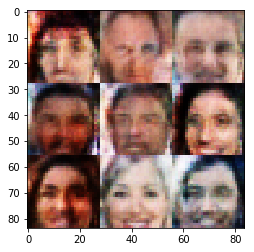

Step: 5110: Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8061
Step: 5120: Epoch 1/1... Discriminator Loss: 3.1519... Generator Loss: 0.1021
Step: 5130: Epoch 1/1... Discriminator Loss: 2.4214... Generator Loss: 0.2121
Step: 5140: Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 6.9499
Step: 5150: Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.6700
Step: 5160: Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.6459
Step: 5170: Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.8048
Step: 5180: Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.2359
Step: 5190: Epoch 1/1... Discriminator Loss: 2.9665... Generator Loss: 0.1203
Step: 5200: Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 6.8273


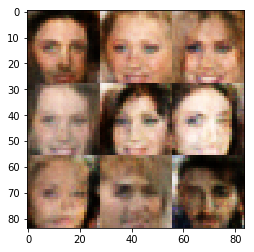

Step: 5210: Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.4514
Step: 5220: Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 2.4728
Step: 5230: Epoch 1/1... Discriminator Loss: 3.7961... Generator Loss: 0.0519
Step: 5240: Epoch 1/1... Discriminator Loss: 2.6563... Generator Loss: 0.1416
Step: 5250: Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.7857
Step: 5260: Epoch 1/1... Discriminator Loss: 2.2836... Generator Loss: 0.2863
Step: 5270: Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 4.3021
Step: 5280: Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 4.8018
Step: 5290: Epoch 1/1... Discriminator Loss: 2.3072... Generator Loss: 0.2153
Step: 5300: Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7717


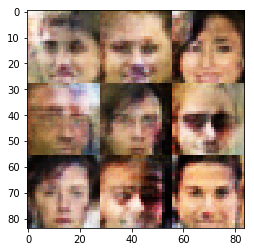

Step: 5310: Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.8622
Step: 5320: Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 0.3586
Step: 5330: Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7547
Step: 5340: Epoch 1/1... Discriminator Loss: 3.8861... Generator Loss: 0.0563
Step: 5350: Epoch 1/1... Discriminator Loss: 2.1013... Generator Loss: 0.3196
Step: 5360: Epoch 1/1... Discriminator Loss: 1.9315... Generator Loss: 0.3613
Step: 5370: Epoch 1/1... Discriminator Loss: 2.3103... Generator Loss: 0.1977
Step: 5380: Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9275
Step: 5390: Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5681
Step: 5400: Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.3727


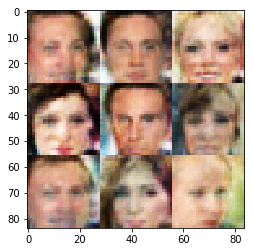

Step: 5410: Epoch 1/1... Discriminator Loss: 2.4633... Generator Loss: 0.1758
Step: 5420: Epoch 1/1... Discriminator Loss: 2.0519... Generator Loss: 0.3196
Step: 5430: Epoch 1/1... Discriminator Loss: 2.2898... Generator Loss: 0.3205
Step: 5440: Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4985
Step: 5450: Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.5186
Step: 5460: Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5391
Step: 5470: Epoch 1/1... Discriminator Loss: 1.7779... Generator Loss: 0.3348
Step: 5480: Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 8.7895
Step: 5490: Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.3999
Step: 5500: Epoch 1/1... Discriminator Loss: 2.5250... Generator Loss: 0.1630


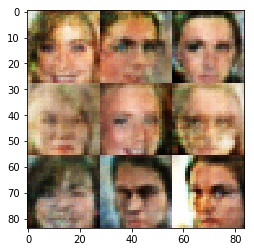

Step: 5510: Epoch 1/1... Discriminator Loss: 1.6631... Generator Loss: 0.3671
Step: 5520: Epoch 1/1... Discriminator Loss: 2.4257... Generator Loss: 0.1535
Step: 5530: Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.5331
Step: 5540: Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.4601
Step: 5550: Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5230
Step: 5560: Epoch 1/1... Discriminator Loss: 2.4580... Generator Loss: 0.1586
Step: 5570: Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6315
Step: 5580: Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.1623
Step: 5590: Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 1.4961
Step: 5600: Epoch 1/1... Discriminator Loss: 2.3278... Generator Loss: 0.2107


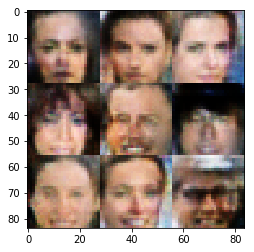

Step: 5610: Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6661
Step: 5620: Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.4107
Step: 5630: Epoch 1/1... Discriminator Loss: 3.6980... Generator Loss: 0.0686
Step: 5640: Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 4.1130
Step: 5650: Epoch 1/1... Discriminator Loss: 2.5526... Generator Loss: 0.1331
Step: 5660: Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.5470
Step: 5670: Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6820
Step: 5680: Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 8.5372
Step: 5690: Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.2919
Step: 5700: Epoch 1/1... Discriminator Loss: 3.4215... Generator Loss: 0.0762


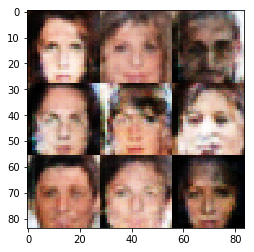

Step: 5710: Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.6315
Step: 5720: Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.7680
Step: 5730: Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 8.6886
Step: 5740: Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5558
Step: 5750: Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9146
Step: 5760: Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.4448
Step: 5770: Epoch 1/1... Discriminator Loss: 2.6401... Generator Loss: 0.1479
Step: 5780: Epoch 1/1... Discriminator Loss: 2.1614... Generator Loss: 0.2166
Step: 5790: Epoch 1/1... Discriminator Loss: 2.1930... Generator Loss: 0.2735
Step: 5800: Epoch 1/1... Discriminator Loss: 3.0907... Generator Loss: 0.1306


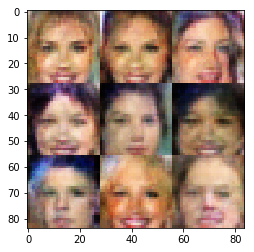

Step: 5810: Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 4.4732
Step: 5820: Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6598
Step: 5830: Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4976
Step: 5840: Epoch 1/1... Discriminator Loss: 3.1681... Generator Loss: 0.0875
Step: 5850: Epoch 1/1... Discriminator Loss: 3.4003... Generator Loss: 0.0856
Step: 5860: Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 6.5221
Step: 5870: Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.9880
Step: 5880: Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.4131
Step: 5890: Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.1833
Step: 5900: Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.4659


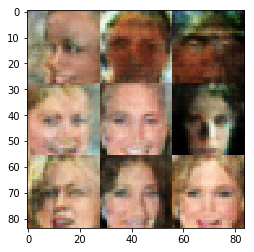

Step: 5910: Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.5158
Step: 5920: Epoch 1/1... Discriminator Loss: 3.0497... Generator Loss: 0.1271
Step: 5930: Epoch 1/1... Discriminator Loss: 2.4234... Generator Loss: 0.2432
Step: 5940: Epoch 1/1... Discriminator Loss: 1.9600... Generator Loss: 0.2568
Step: 5950: Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.1912
Step: 5960: Epoch 1/1... Discriminator Loss: 1.9695... Generator Loss: 0.2668
Step: 5970: Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.1676
Step: 5980: Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.4654
Step: 5990: Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.8780
Step: 6000: Epoch 1/1... Discriminator Loss: 1.7676... Generator Loss: 0.3517


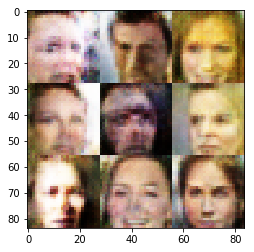

Step: 6010: Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 3.7649
Step: 6020: Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.8481
Step: 6030: Epoch 1/1... Discriminator Loss: 3.1013... Generator Loss: 0.0968
Step: 6040: Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.3057
Step: 6050: Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.6487
Step: 6060: Epoch 1/1... Discriminator Loss: 3.1861... Generator Loss: 0.1025
Step: 6070: Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 3.0399
Step: 6080: Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.0851
Step: 6090: Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6385
Step: 6100: Epoch 1/1... Discriminator Loss: 1.9193... Generator Loss: 0.3240


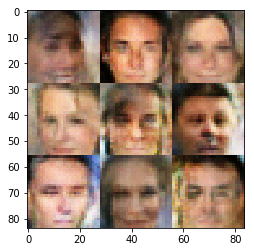

Step: 6110: Epoch 1/1... Discriminator Loss: 2.1861... Generator Loss: 0.2338
Step: 6120: Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5559
Step: 6130: Epoch 1/1... Discriminator Loss: 2.8019... Generator Loss: 0.2024
Step: 6140: Epoch 1/1... Discriminator Loss: 2.4271... Generator Loss: 0.2331
Step: 6150: Epoch 1/1... Discriminator Loss: 3.2303... Generator Loss: 0.1055
Step: 6160: Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4944
Step: 6170: Epoch 1/1... Discriminator Loss: 3.5289... Generator Loss: 0.0612
Step: 6180: Epoch 1/1... Discriminator Loss: 1.7707... Generator Loss: 0.3445
Step: 6190: Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7058
Step: 6200: Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7369


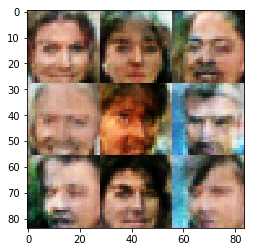

Step: 6210: Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.1070
Step: 6220: Epoch 1/1... Discriminator Loss: 1.8508... Generator Loss: 0.2913
Step: 6230: Epoch 1/1... Discriminator Loss: 3.1290... Generator Loss: 0.1026
Step: 6240: Epoch 1/1... Discriminator Loss: 3.1262... Generator Loss: 0.1043
Step: 6250: Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.6978
Step: 6260: Epoch 1/1... Discriminator Loss: 2.3249... Generator Loss: 0.1992
Step: 6270: Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.3545
Step: 6280: Epoch 1/1... Discriminator Loss: 1.9940... Generator Loss: 0.2792
Step: 6290: Epoch 1/1... Discriminator Loss: 2.3395... Generator Loss: 0.2508
Step: 6300: Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.1908


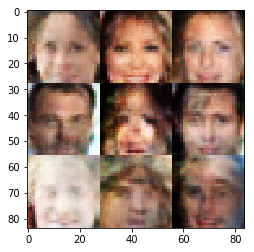

Step: 6310: Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.5679
Step: 6320: Epoch 1/1... Discriminator Loss: 3.8243... Generator Loss: 0.0584


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.